In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from stable_baselines3 import PPO
import gym
import numpy as np

### New Approach

In [2]:
from datasets import load_dataset

# Load a small subset (1%) of the CNN/DailyMail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1%]")
texts = dataset["article"]  # Extract news articles
summaries = dataset["highlights"]  # Extract summaries

print(f"Loaded {len(texts)} samples from CNN/DailyMail dataset")

Loaded 2871 samples from CNN/DailyMail dataset


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Use a lightweight model to fit into memory
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
model = GPT2LMHeadModel.from_pretrained("distilgpt2")

In [4]:
# RL Enviroment
import gym
from gym import spaces
import numpy as np
import torch

class AdaptiveContextEnv(gym.Env):
    def __init__(self, texts, summaries, model, tokenizer):
        super(AdaptiveContextEnv, self).__init__()
        self.model = model
        self.texts = texts
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.action_space = spaces.Discrete(4)  # Context lengths: [50, 100, 150, 250]
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)

    def step(self, action):
        context_lengths = [50, 100, 150, 250]
        context_length = context_lengths[action]

        # Sample a random text
        idx = np.random.randint(len(self.texts))
        text = self.texts[idx]
        ref_summary = self.summaries[idx]

        tokenized_input = self.tokenizer.encode(text, truncation=True, max_length=context_length)
        generated_summary = self.generate_summary(tokenized_input)

        # Compute ROUGE score for evaluation
        rouge_score = self.compute_rouge(generated_summary, ref_summary)

        # Efficiency reward (shorter context is better)
        efficiency = context_length / 250  # Normalize efficiency score
        reward = rouge_score * 100 + efficiency * 10  # Trade-off between task performance & efficiency

        return np.array([efficiency], dtype=np.float32), reward, True, {}

    def reset(self):
        return np.array([0.0], dtype=np.float32)

    def generate_summary(self, tokenized_input):
        """Generates a summary from the model output using max_new_tokens."""
        input_ids = torch.tensor([tokenized_input])

        with torch.no_grad():
            output = self.model.generate(input_ids, max_new_tokens=50, num_return_sequences=1)

        return self.tokenizer.decode(output[0], skip_special_tokens=True)

    def compute_rouge(self, generated_summary, ref_summary):
        """Compute ROUGE-L score for summarization performance."""
        import evaluate
        rouge = evaluate.load("rouge")
        scores = rouge.compute(predictions=[generated_summary], references=[ref_summary])
    
        # If ROUGE returns a single float, return it directly
        if isinstance(scores["rougeL"], float):
            return scores["rougeL"]
        
        # Otherwise, return the F1 score
        return scores["rougeL"].fmeasure

In [7]:
import torch
print(torch.cuda.get_device_name(0))  # Should show your GPU name
print(torch.cuda.is_available())      # Should be True

AssertionError: Torch not compiled with CUDA enabled

In [6]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap environment for Stable-Baselines3 PPO training
env = DummyVecEnv([lambda: AdaptiveContextEnv(texts, summaries, model, tokenizer)])

# Initialize PPO agent
agent = PPO("MlpPolicy", env, verbose=1, clip_range=0.2, max_grad_norm=0.5, device="cuda")

# Train for a small number of steps to fit into 16GB RAM
agent.learn(total_timesteps=3000)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Using cpu device


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 

In [13]:
# Evaluate adaptive model
selected_lengths = []
rouge_scores = []
num_samples = 50  # Test on 50 samples

for _ in range(num_samples):
    obs = env.reset()
    done = False
    while not done:
        action, _ = agent.predict(obs)
        selected_lengths.append(action)
        obs, reward, done, _ = env.step(action)

    rouge_scores.append(reward)

# Compute average ROUGE score
avg_rouge = np.mean(rouge_scores)
print(f"Average ROUGE Score: {avg_rouge:.4f}")

# Compute average selected context length
selected_lengths = np.array([50, 100, 150, 250])[selected_lengths]
avg_context_length = np.mean(selected_lengths)
print(f"Average Selected Context Length: {avg_context_length:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Average ROUGE Score: 23.7760
Average Selected Context Length: 136.00


In [1]:
print(selected_lengths)

NameError: name 'selected_lengths' is not defined

In [14]:
import time

def measure_efficiency(model, tokenizer, texts, max_length=250):
    total_tokens = 0
    start_time = time.time()

    for text in texts[:100]:  # Test on 100 samples
        input_ids = tokenizer.encode(text, truncation=True, max_length=max_length)
        total_tokens += len(input_ids)

        with torch.no_grad():
            _ = model(torch.tensor([input_ids]))

    end_time = time.time()
    time_taken = end_time - start_time

    tokens_per_sec = total_tokens / time_taken
    avg_context_length = total_tokens / len(texts[:100])

    return tokens_per_sec, avg_context_length

tokens_sec, avg_length = measure_efficiency(model, tokenizer, texts)
print(f"Tokens processed per second: {tokens_sec:.2f}")
print(f"Average context length used: {avg_length:.2f}")

Tokens processed per second: 1318.60
Average context length used: 248.88


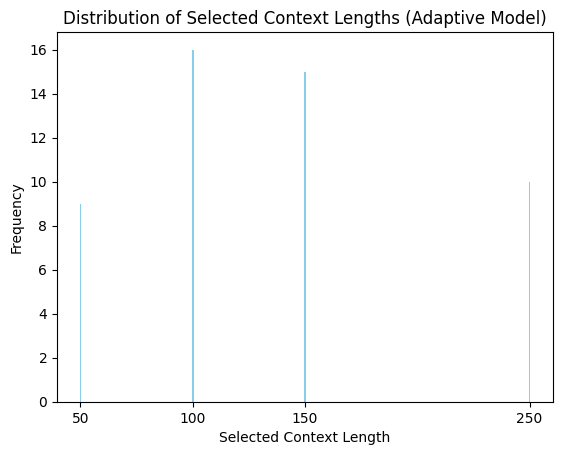

In [15]:
import matplotlib.pyplot as plt

# Count occurrences of selected context lengths
unique, counts = np.unique(selected_lengths, return_counts=True)
plt.bar(unique, counts, color="skyblue")

plt.xlabel("Selected Context Length")
plt.ylabel("Frequency")
plt.title("Distribution of Selected Context Lengths (Adaptive Model)")
plt.xticks([50, 100, 150, 250])
plt.show()

In [17]:
def compute_rouge(generated_summary, ref_summary):
        """Compute ROUGE-L score for summarization performance."""
        import evaluate
        rouge = evaluate.load("rouge")
        scores = rouge.compute(predictions=[generated_summary], references=[ref_summary])
    
        # If ROUGE returns a single float, return it directly
        if isinstance(scores["rougeL"], float):
            return scores["rougeL"]
        
        # Otherwise, return the F1 score
        return scores["rougeL"].fmeasure

In [18]:
fixed_contexts = [50, 100, 150, 250]
fixed_rouge_scores = {}

for ctx in fixed_contexts:
    rouge_scores = []
    
    for i in range(50):  # Evaluate on 50 samples
        text = texts[i]
        ref_summary = summaries[i]

        # Tokenize with fixed context length
        tokenized_input = tokenizer.encode(text, truncation=True, max_length=ctx)

        # Generate summary
        input_ids = torch.tensor([tokenized_input])
        with torch.no_grad():
            output = model.generate(input_ids, max_new_tokens=50)
        generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)

        # Compute ROUGE score
        rouge_score = compute_rouge(generated_summary, ref_summary)
        rouge_scores.append(rouge_score)

    fixed_rouge_scores[ctx] = np.mean(rouge_scores)

print(f"Fixed Context ROUGE Scores: {fixed_rouge_scores}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

Fixed Context ROUGE Scores: {50: np.float64(0.19933677217080695), 100: np.float64(0.20589539632825943), 150: np.float64(0.17627178125049447), 250: np.float64(0.13691890681174573)}


In [19]:
print(f"Adaptive Model - Avg ROUGE: {avg_rouge:.4f}, Avg Context Length: {avg_context_length:.2f}")

for ctx, rouge in fixed_rouge_scores.items():
    print(f"Fixed {ctx} Tokens - ROUGE: {rouge:.4f}")

Adaptive Model - Avg ROUGE: 23.7760, Avg Context Length: 136.00
Fixed 50 Tokens - ROUGE: 0.1993
Fixed 100 Tokens - ROUGE: 0.2059
Fixed 150 Tokens - ROUGE: 0.1763
Fixed 250 Tokens - ROUGE: 0.1369


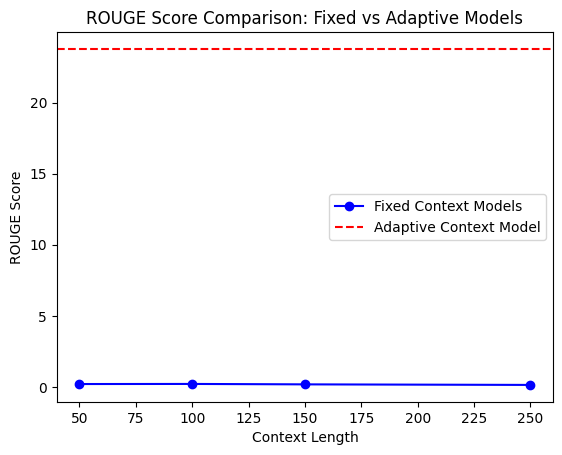

In [20]:
import matplotlib.pyplot as plt

# Plot fixed-context models
plt.plot(fixed_contexts, list(fixed_rouge_scores.values()), marker="o", label="Fixed Context Models", color="blue")

# Plot adaptive model result
plt.axhline(y=avg_rouge, color="red", linestyle="--", label="Adaptive Context Model")

plt.xlabel("Context Length")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Score Comparison: Fixed vs Adaptive Models")
plt.legend()
plt.show()

In [21]:
print(f"Adaptive Model - Tokens/sec: {tokens_sec:.2f}, Avg Context Length: {avg_context_length:.2f}")

for ctx in fixed_contexts:
    tokens_sec_fixed, avg_length_fixed = measure_efficiency(model, tokenizer, texts[:50], max_length=ctx)
    print(f"Fixed {ctx} Tokens - Tokens/sec: {tokens_sec_fixed:.2f}, Avg Context Length: {avg_length_fixed:.2f}")

Adaptive Model - Tokens/sec: 1318.60, Avg Context Length: 136.00
Fixed 50 Tokens - Tokens/sec: 840.21, Avg Context Length: 50.00
Fixed 100 Tokens - Tokens/sec: 1181.79, Avg Context Length: 100.00
Fixed 150 Tokens - Tokens/sec: 1295.13, Avg Context Length: 150.00
Fixed 250 Tokens - Tokens/sec: 1369.75, Avg Context Length: 249.42
